In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


C:\ProgramData\Anaconda3\envs\PyTorch37\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [19]:
# 设置一个随机种子，方便进行可重复性实验
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# 数据集所在路径
dataroot = "C:/Users/矿大物联网/Desktop/研究僧/论文整理/GAN网络/code/gan_mnist-master/archive"
# 数据加载的进程数
workers = 0
# Batch size 大小
batch_size = 128
# Spatial size of training images. All images will be resized to this
# size using a transformer.
# 图片大小
image_size = 64   #64

# 图片的通道数
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64 #64
# Size of feature maps in discriminator
ndf = 64 #64
# Number of training epochs
num_epochs = 100
# Learning rate for optimizers
lr = 0.0003
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")



Random Seed:  999


In [4]:

# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


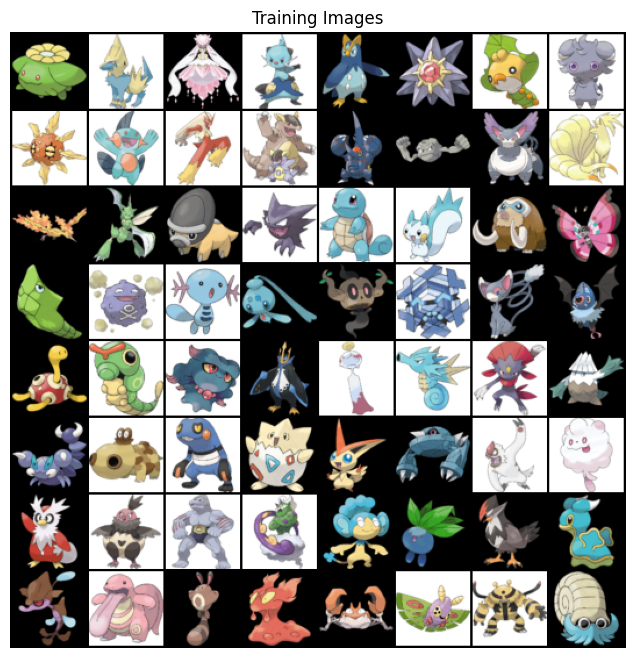

In [5]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
# plt.show()


In [6]:
# 权重初始化函数，为生成器和判别器模型初始化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)



In [15]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
# to mean=0, stdev=0.2.
netG.apply(weights_init)
# Print the model
print(netG)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)




Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [8]:
# Initialize BCELoss function
criterion = nn.BCELoss()


In [20]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    import time
    start = time.time()
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 13 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 20 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):

            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()

            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            i = vutils.make_grid(fake, padding=2, normalize=True)
            fig = plt.figure(figsize=(8, 8))
            plt.imshow(np.transpose(i, (1, 2, 0)))
            plt.axis('off')  # 关闭坐标轴
            plt.savefig("out/%d_%d.png" % (epoch, iters))
            plt.close(fig)
        iters += 1
    print('time:', time.time() - start)



Starting Training Loop...
[0/100][0/26]	Loss_D: 0.3408	Loss_G: 8.1302	D(x): 0.9398	D(G(z)): 0.2150 / 0.0022
[0/100][13/26]	Loss_D: 0.7799	Loss_G: 3.7032	D(x): 0.7729	D(G(z)): 0.3267 / 0.0403
time: 3.7002902030944824
[1/100][0/26]	Loss_D: 0.5396	Loss_G: 4.1555	D(x): 0.9192	D(G(z)): 0.3189 / 0.0254
[1/100][13/26]	Loss_D: 0.3880	Loss_G: 4.0722	D(x): 0.9013	D(G(z)): 0.2099 / 0.0332
time: 3.438683271408081
[2/100][0/26]	Loss_D: 0.6884	Loss_G: 4.3581	D(x): 0.8850	D(G(z)): 0.3176 / 0.0480
[2/100][13/26]	Loss_D: 0.6621	Loss_G: 3.3945	D(x): 0.8551	D(G(z)): 0.3392 / 0.0614
time: 3.44996976852417
[3/100][0/26]	Loss_D: 0.4311	Loss_G: 4.0839	D(x): 0.8936	D(G(z)): 0.2343 / 0.0469
[3/100][13/26]	Loss_D: 0.9722	Loss_G: 3.3197	D(x): 0.8468	D(G(z)): 0.3732 / 0.1708
time: 3.670400857925415
[4/100][0/26]	Loss_D: 0.7152	Loss_G: 2.3630	D(x): 0.5524	D(G(z)): 0.0297 / 0.1976
[4/100][13/26]	Loss_D: 1.1410	Loss_G: 3.9550	D(x): 0.8363	D(G(z)): 0.4481 / 0.0366
time: 3.465932607650757
[5/100][0/26]	Loss_D: 0.3302	

time: 3.4673144817352295
[43/100][0/26]	Loss_D: 0.0520	Loss_G: 6.1888	D(x): 0.9550	D(G(z)): 0.0051 / 0.0053
[43/100][13/26]	Loss_D: 0.1016	Loss_G: 4.4061	D(x): 0.9730	D(G(z)): 0.0683 / 0.0262
time: 3.7809574604034424
[44/100][0/26]	Loss_D: 0.0702	Loss_G: 4.4027	D(x): 0.9721	D(G(z)): 0.0395 / 0.0365
[44/100][13/26]	Loss_D: 0.0835	Loss_G: 4.2078	D(x): 0.9767	D(G(z)): 0.0565 / 0.0314
time: 3.495976686477661
[45/100][0/26]	Loss_D: 0.3108	Loss_G: 4.1414	D(x): 0.7702	D(G(z)): 0.0109 / 0.0461
[45/100][13/26]	Loss_D: 0.8968	Loss_G: 4.1562	D(x): 0.5379	D(G(z)): 0.0045 / 0.0685
time: 3.495645046234131
[46/100][0/26]	Loss_D: 0.3370	Loss_G: 4.8013	D(x): 0.7754	D(G(z)): 0.0396 / 0.0267
[46/100][13/26]	Loss_D: 0.5408	Loss_G: 3.6623	D(x): 0.7582	D(G(z)): 0.1588 / 0.1035
time: 3.723647117614746
[47/100][0/26]	Loss_D: 0.4823	Loss_G: 4.7995	D(x): 0.7146	D(G(z)): 0.0405 / 0.0433
[47/100][13/26]	Loss_D: 0.0592	Loss_G: 5.7157	D(x): 0.9587	D(G(z)): 0.0161 / 0.0080
time: 3.5706818103790283
[48/100][0/26]	Los

time: 3.5629212856292725
[86/100][0/26]	Loss_D: 0.0326	Loss_G: 4.5396	D(x): 0.9919	D(G(z)): 0.0236 / 0.0193
[86/100][13/26]	Loss_D: 0.0618	Loss_G: 5.8512	D(x): 0.9459	D(G(z)): 0.0031 / 0.0112
time: 3.754138946533203
[87/100][0/26]	Loss_D: 0.0934	Loss_G: 4.4030	D(x): 0.9393	D(G(z)): 0.0269 / 0.0376
[87/100][13/26]	Loss_D: 0.2508	Loss_G: 6.1698	D(x): 0.7953	D(G(z)): 0.0016 / 0.0039
time: 3.445762872695923
[88/100][0/26]	Loss_D: 0.0785	Loss_G: 4.5822	D(x): 0.9806	D(G(z)): 0.0540 / 0.0190
[88/100][13/26]	Loss_D: 0.0363	Loss_G: 4.3234	D(x): 0.9923	D(G(z)): 0.0278 / 0.0236
time: 3.4463489055633545
[89/100][0/26]	Loss_D: 0.0291	Loss_G: 6.7155	D(x): 0.9764	D(G(z)): 0.0049 / 0.0042
[89/100][13/26]	Loss_D: 0.0872	Loss_G: 3.7040	D(x): 0.9648	D(G(z)): 0.0484 / 0.0372
time: 3.4526610374450684
[90/100][0/26]	Loss_D: 0.0880	Loss_G: 4.1962	D(x): 0.9818	D(G(z)): 0.0639 / 0.0209
[90/100][13/26]	Loss_D: 0.1040	Loss_G: 4.7240	D(x): 0.9755	D(G(z)): 0.0718 / 0.0134
time: 3.769453525543213
[91/100][0/26]	Los

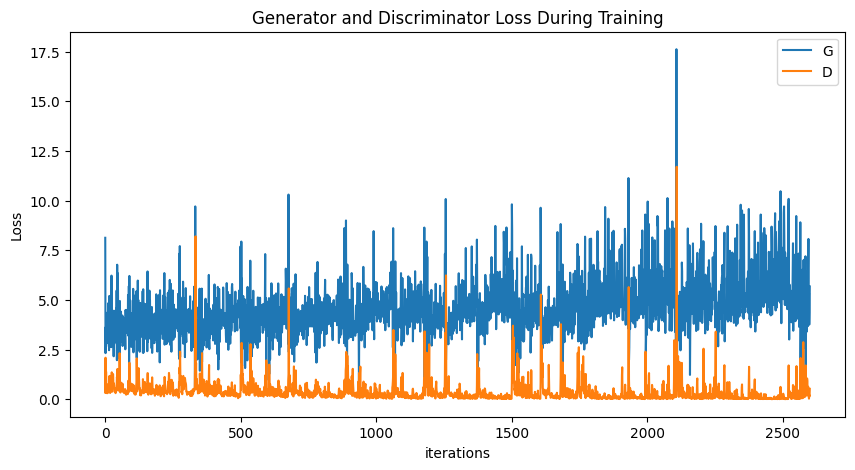

In [21]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()




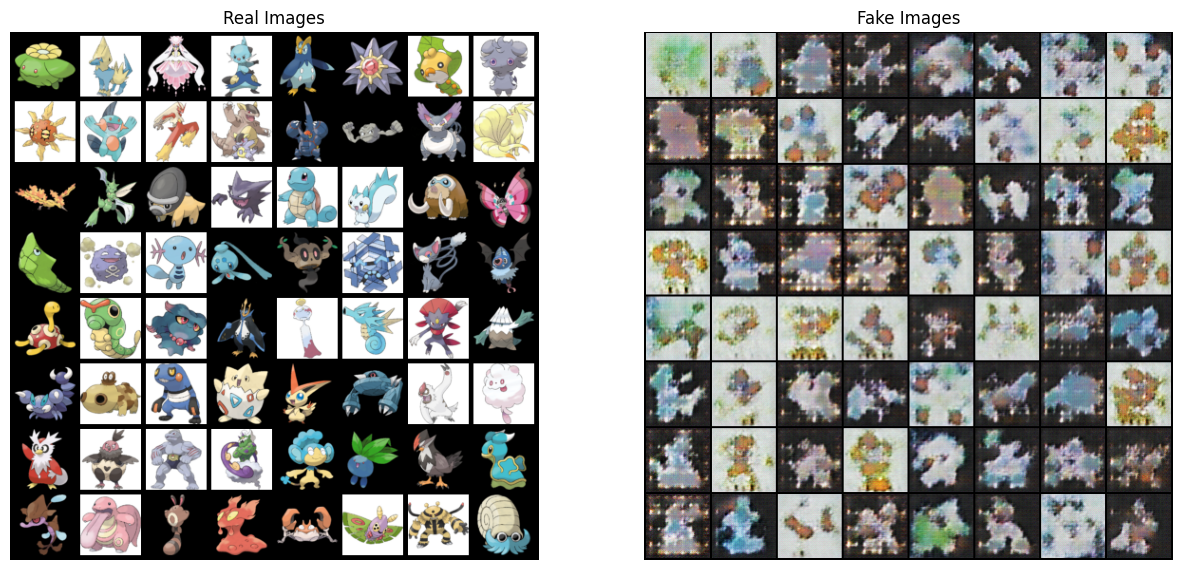

In [22]:
# Grab a batch of real images from the dataloader
# real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()



In [23]:
%pwd

'C:\\Users\\矿大物联网'